# Analyze simulated library of codon variants
Simulate a “plausible” data set of barcoded codon variants, then analyzes it.

## Setup for analysis

Import Python modules / packages:

In [1]:
import itertools
import random
import tempfile
import warnings

from IPython.display import display, Image

import pandas as pd

from plotnine import *

import scipy

from dms_variants.codonvarianttable import CodonVariantTable
from dms_variants.constants import (CBPALETTE,
                                    CODONS_NOSTOP,
                                    )
from dms_variants.simulate import (simulateSampleCounts,
                                   simulate_CodonVariantTable,
                                   SigmoidPhenotypeSimulator,
                                   )

Set parameters that define the simulate data:

In [2]:
seed = 1  # random number seed
genelength = 50  # gene length in codons
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.05  # rate at which variant mis-called
depth = 200 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.02  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 100,
        }

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter('ignore')

## Simulate library of variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 50 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGA


Generate a [CodonVariantTable](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) using [simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable) function:

In [7]:
variants = simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                 'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

We can get basic information about the `CodonVariantTable`, such as the sites, wildtype codons, and wildtype amino acids.
Below we do this for the first few sites:

In [8]:
variants.sites[: 5]

[1, 2, 3, 4, 5]

In [9]:
list(variants.codons[r] for r in variants.sites[: 5])

['AGA', 'TCC', 'GTG', 'ATT', 'CTG']

In [10]:
list(variants.aas[r] for r in variants.sites[: 5])

['R', 'S', 'V', 'I', 'L']

A list of the different libraries in the table:

In [11]:
variants.libraries

['lib_1', 'lib_2']

Here is the data frame that contains all of the information on the barcoded variants (just looking at the first few lines)

In [12]:
variants.barcode_variant_df.head(n=6)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,AAAAAAACTAAAAGTC,1,,,0,0
1,lib_1,AAAAAAAGACGCGACA,1,,,0,0
2,lib_1,AAAAAAATAGTCAAAG,1,TCA11TAT,S11Y,1,1
3,lib_1,AAAAAACATACTTTAC,1,CTG30CAC GTA45TGC,L30H V45C,2,2
4,lib_1,AAAAAAGATTCCACGT,1,TCC2GTG ATG32GGG CGC48CTT,S2V M32G R48L,3,3
5,lib_1,AAAAAAGCCCAGCCCA,1,GCT7TAT ACC9GTT,A7Y T9V,2,2


## Analyze library composition
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) has methods for summarizing and plotting properties of the barcoded variants.
These methods can be used to analyze the barcoded variants themselves, or to analyze the frequency (or counts) of variants in the library in samples that have undergone some type of selection.
So for we have not added counts of the variants in any specific samples, so we just analyze the composition of the variant library itself.
This is done by setting `samples=None` in the method calls below.

Get the number of variants in each library:

In [13]:
variants.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,25000
1,lib_2,barcoded variants,25000
2,all libraries,barcoded variants,50000


Get the set of valid barcodes for each library:

In [14]:
for lib in libs:
    print(f"First few barcodes for library {lib}:")
    print(sorted(variants.valid_barcodes(lib))[ : 3])

First few barcodes for library lib_1:
['AAAAAAACTAAAAGTC', 'AAAAAAAGACGCGACA', 'AAAAAAATAGTCAAAG']
First few barcodes for library lib_2:
['AAAAAAAATAGGTGAA', 'AAAAAAACACATTAAG', 'AAAAAACCTCGTACGC']


Plot the number of amino-acid mutations per variant:

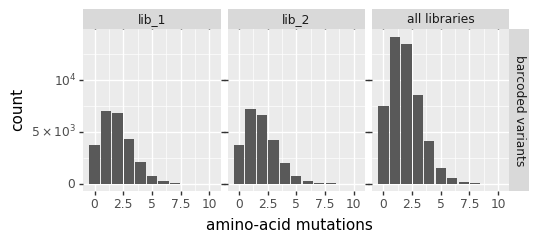

In [15]:
p = variants.plotNumMutsHistogram('aa', samples=None)
_ = p.draw()

Number of codon mutations per variant:

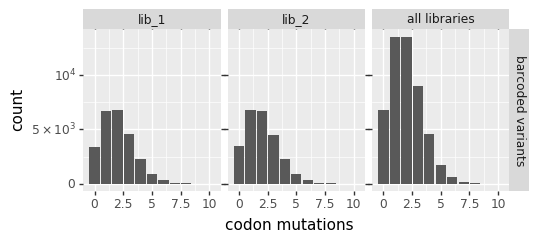

In [16]:
p = variants.plotNumMutsHistogram('codon', samples=None)
_ = p.draw()

Average number of codon mutations per variant of each type of codon mutation.
First, for just single-mutant and wildtype variants:

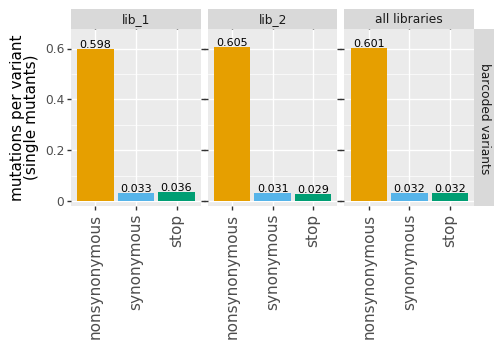

In [17]:
p = variants.plotNumCodonMutsByType('single', samples=None)
_ = p.draw()

Now for variants with any number of mutations:

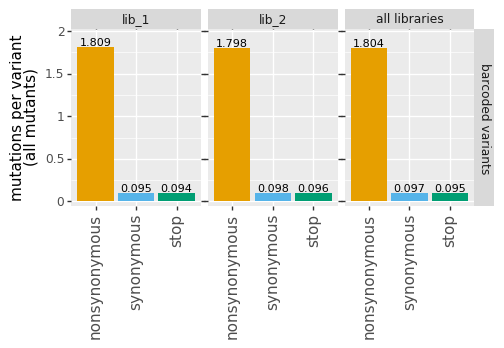

In [18]:
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

Examine how well mutations are sampled in the library by looking at the
fraction of mutations seen <= some number of times.
Here we do that for codon and amino-acid mutations, making separate plots for single mutants and all mutants:

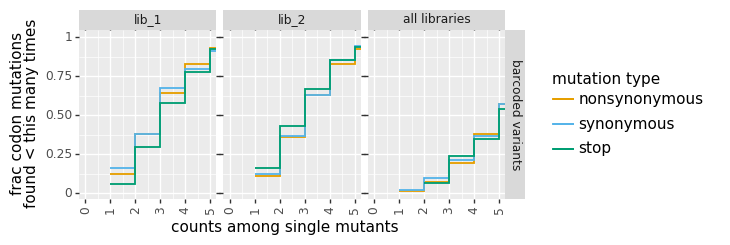

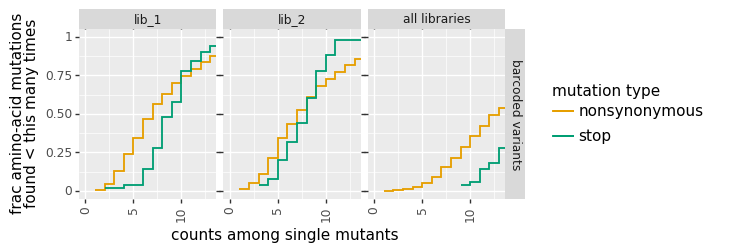

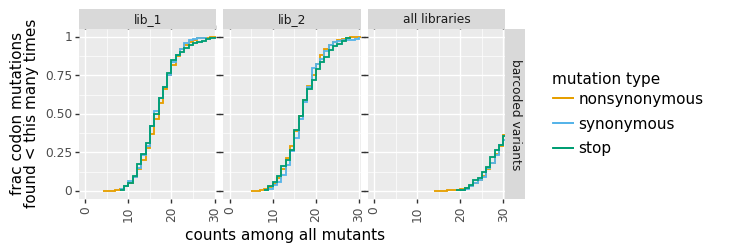

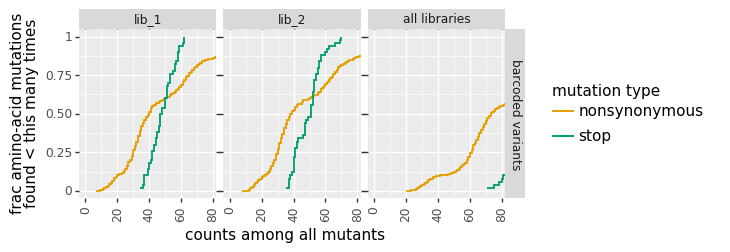

In [19]:
for variant_type, mut_type in itertools.product(
            ['single', 'all'],
            ['codon', 'aa']):
    p = variants.plotCumulMutCoverage(variant_type,
                                      mut_type,
                                      samples=None)
    _ = p.draw()

We can also get the numerical information plotted above (here for single mutants only):

In [20]:
variants.mutCounts('single', 'aa', samples=None).head(n=5)

,library,sample,mutation,count,mutation_type,site
0,lib_1,barcoded variants,H35L,25,nonsynonymous,35
1,lib_1,barcoded variants,C19R,23,nonsynonymous,19
2,lib_1,barcoded variants,R1L,22,nonsynonymous,1
3,lib_1,barcoded variants,I28S,21,nonsynonymous,28
4,lib_1,barcoded variants,L5R,21,nonsynonymous,5


Here are the frequencies of mutations along the gene, looking both at single mutants and all mutants:

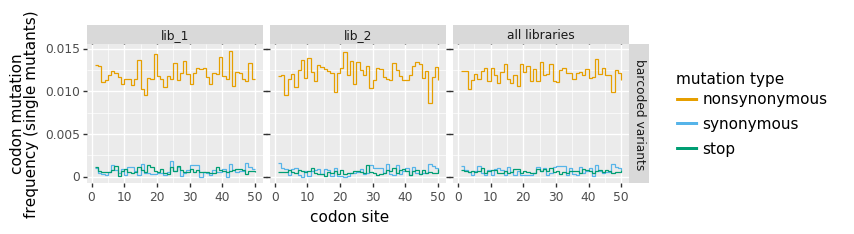

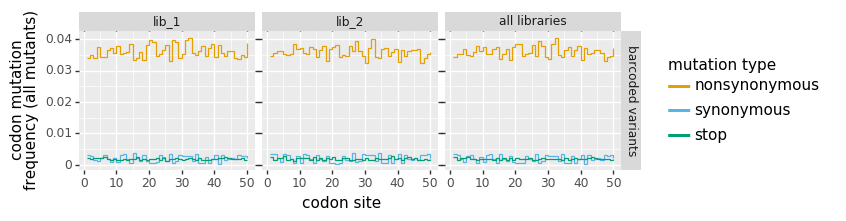

In [21]:
for variant_type in ['single', 'all']:
    p = variants.plotMutFreqs(variant_type,
                              'codon', 
                              samples=None)
    _ = p.draw()

We can also look at mutation frequencies in a heat-map form:

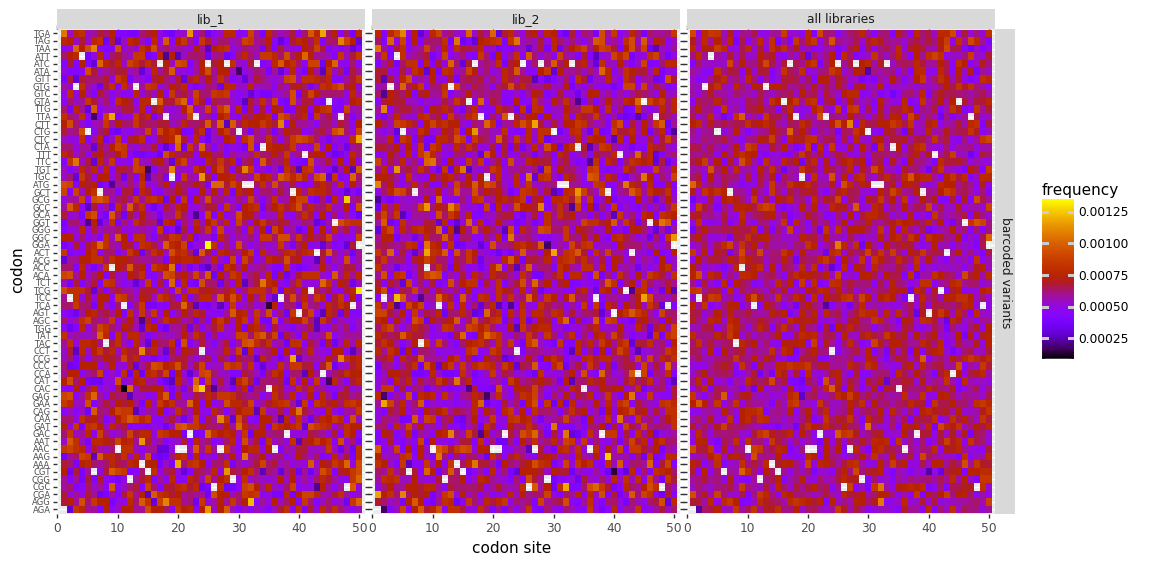

In [22]:
p = variants.plotMutHeatmap('all', 'codon', samples=None)
_ = p.draw()

And we can do the same for amino-acid mutations:

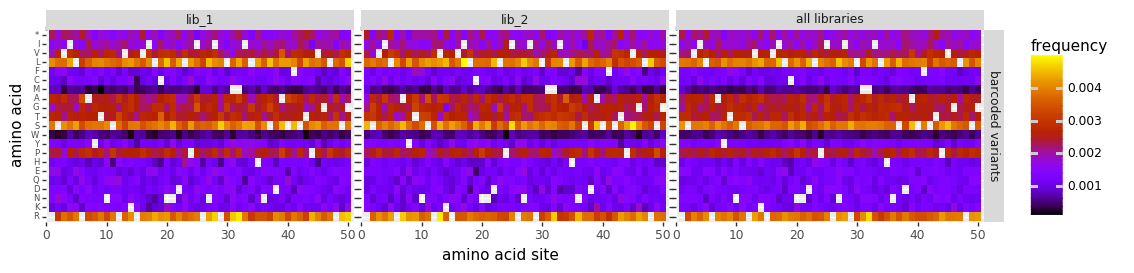

In [23]:
p = variants.plotMutHeatmap('all', 'aa', samples=None)
_ = p.draw()

## Simulate counts for samples
An experiment involves subjecting the library to different selections and looking at how the frequencies of the variants changes by using sequencing to count the barcodes in each condition.

Here, we simulate an experiment by simulating variant counts for samples that have undergone various selections.

For these simulations, we first need to define a "phenotype" for each variant.
The phenotype represents how much the frequency of the variant is expected to increase or decrease after selection.

### Define phenotype function
First, we define a “phenotype” function. We will do this using a [SigmoidPhenotypeSimulator](https://jbloomlab.github.io/dms_variants.simulate.html#dms_variants.simulate.SigmoidPhenotypeSimulator), which follow the "global epistasis" concepts of [Otwinoski et
al](https://doi.org/10.1073/pnas.1804015115) and [Sailer and
Harms](https://doi.org/10.1534/genetics.116.195214) to define the phenotype in two steps: an underlying latent phenotype that mutations affect additively, and then an observed phenotype that is a non-linear (in this case, sigmoidal) function of the latent phenotype.

First, we initialize the simulator:

In [24]:
phenosimulator = SigmoidPhenotypeSimulator(geneseq,
                                           seed=seed)

Plot the relationship of the latent and observed phenotypes, with a dashed vertical line indicating the wildtype phenotype:

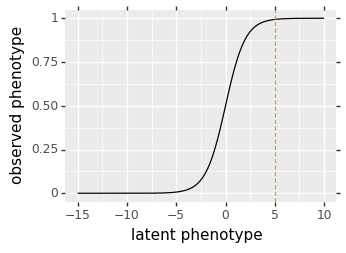

In [25]:
p = phenosimulator.plotLatentVsObserved()
_ = p.draw()

Plot the latent and observed phenotypes of all single amino-acid mutants, with a dashed vertical line indicating the wildtype phenotype:

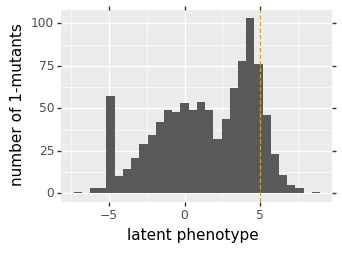

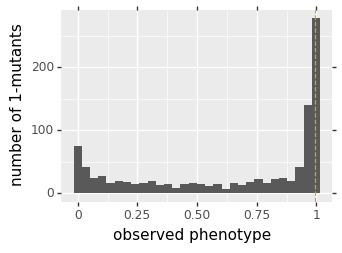

In [26]:
for phenotype in ['latent', 'observed']:
    p = phenosimulator.plotMutsHistogram(phenotype)
    _ = p.draw()

### Simulate variant counts
Now we use
[simulateSampleCounts](https://jbloomlab.github.io/dms_variants.simulate.html#dms_variants.simulate.simulateSampleCounts) to simulate counts of variants when selection on each variant is proportional to its observed phenotype.
In these simulations, we can fine-tune the simulations to reflect real experiments, such as by setting the error-rate in variant calling, bottlenecks when going from the pre- to post-selection samples, and non-uniformity in library composition.

Here we simulate using several bottlenecks in the library going from the pre- to post-selection samples, since in real experiments this seems to be the biggest source of noise / error:

In [27]:
counts = simulateSampleCounts(
            variants=variants,
            phenotype_func=phenosimulator.observedPhenotype,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

First few lines of the data frame with the simulated counts:

In [28]:
counts.head(n=5)

,library,barcode,sample,count
0,lib_1,AAAAAAACTAAAAGTC,pre-selection,237
1,lib_1,AAAAAAAGACGCGACA,pre-selection,78
2,lib_1,AAAAAAATAGTCAAAG,pre-selection,88
3,lib_1,AAAAAACATACTTTAC,pre-selection,184
4,lib_1,AAAAAAGATTCCACGT,pre-selection,93


### Add counts to variant table
Now add the simulated counts for each library / sample to the
[CodonVariantTable](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable):

In [29]:
for (lib, sample), df in counts.groupby(['library',
                                         'sample'],
                                         sort=False):
    variants.addSampleCounts(lib, sample, df)

We can confirm that we have added the expected number of counts per library / sample:

In [30]:
variants.n_variants_df()

,library,sample,count
0,lib_1,pre-selection,5000000
1,lib_1,loose_bottle,5000000
2,lib_1,tight_bottle,5000000
3,lib_2,pre-selection,5000000
4,lib_2,loose_bottle,5000000
5,lib_2,tight_bottle,5000000
6,all libraries,pre-selection,10000000
7,all libraries,loose_bottle,10000000
8,all libraries,tight_bottle,10000000


## Analyze sample variant counts
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) has methods for summarizing and plotting the variant counts for different samples.
These methods are mostly the same as we used above to analyze the variant composition of the libraries themselves, but now we set `samples` to the samples that we want to analyze (typically 'all').
Therefore, rather than each variant always counting once, each variant is counted in each sample in proportion to how many counts it has.

In the rawest form, we can directly access a data frame giving the counts of each variant in each sample:

In [31]:
variants.variant_count_df.head(n=5)

,barcode,count,library,sample,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,TCATGCCGTTTGAAAC,879,lib_1,pre-selection,1,GAC22ATT CCT24TTA ATC28CGC CGC48GAG GGA50GAC,D22I P24L I28R R48E G50D,5,5
1,TCTCGCTTCGTCCTAT,813,lib_1,pre-selection,1,GTG13TAC TGC19TGG TCG42CCC,V13Y C19W S42P,3,3
2,ATCATCGATCGCTTGG,765,lib_1,pre-selection,1,ATT4CAT CGT6ATC TCG42GCC,I4H R6I S42A,3,3
3,ATGGGGTGGCATTGAA,755,lib_1,pre-selection,1,ATT4TCA AGT40CTG GTA45TCT,I4S S40L V45S,3,3
4,GGCGGGTTCGACGGCA,724,lib_1,pre-selection,1,AAC21AAA TTA47CGC,N21K L47R,2,2


Plot the number of counts for each variant in each sample. 
The horizontal dashed line shows the total number of variants. 
The plot shows that all variants are well-sampled in the pre-selection libraries, but that post-selection some variants are sampled more or less.
This is expected since selection will decrease and increase the frequency of variants:

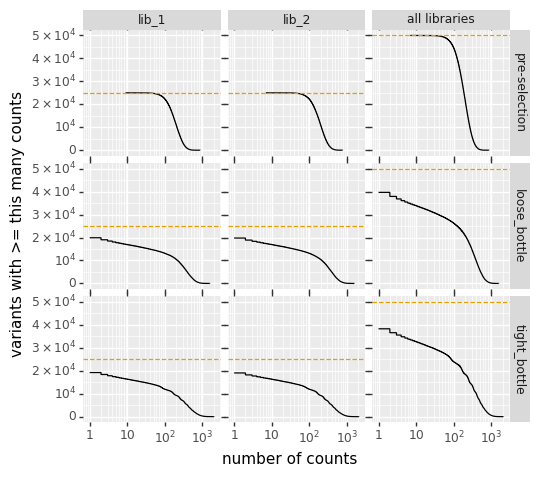

In [32]:
p = variants.plotCumulVariantCounts()
_ = p.draw()

Here is the distribution of the number of mutations per variant in each sample.
As expected, mutations go down after selection:

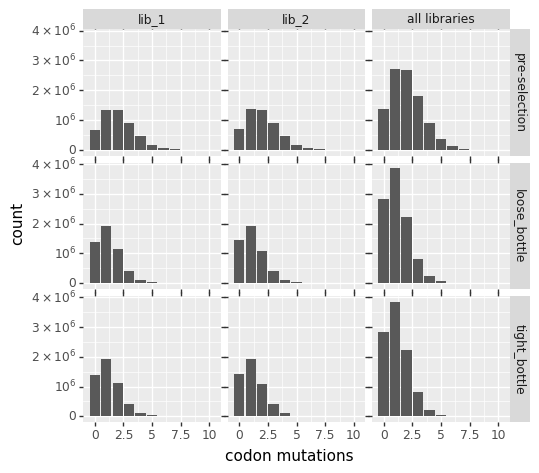

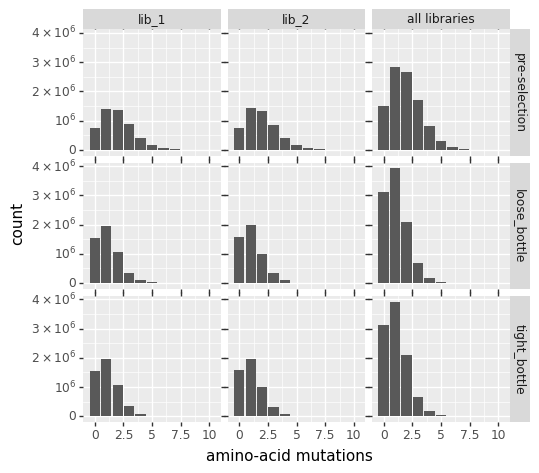

In [33]:
for mut_type in ['codon', 'aa']:
    p = variants.plotNumMutsHistogram(mut_type=mut_type)
    _ = p.draw()

Here is the average number of mutations per variant among just single mutants (and wildtype) and among all variants:

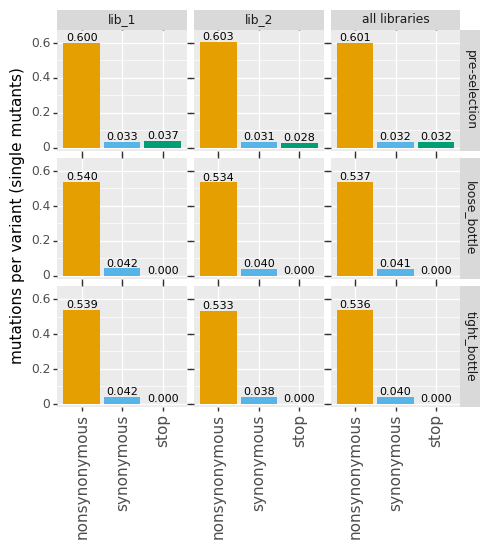

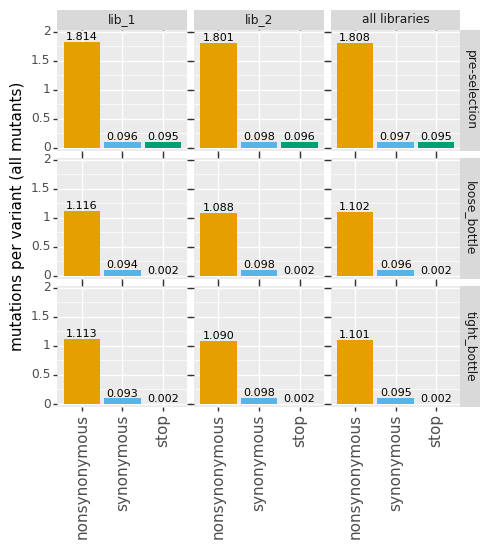

In [34]:
for variant_type in ['single', 'all']:
    p = variants.plotNumCodonMutsByType(variant_type)
    _ = p.draw()

Here are mutation frequencies as a function of primary sequence:

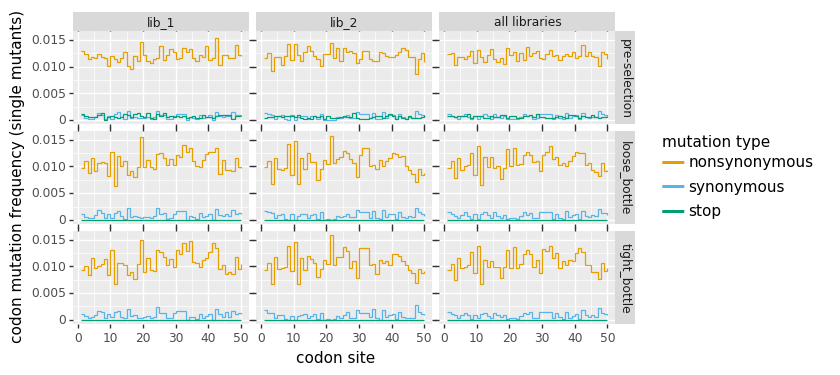

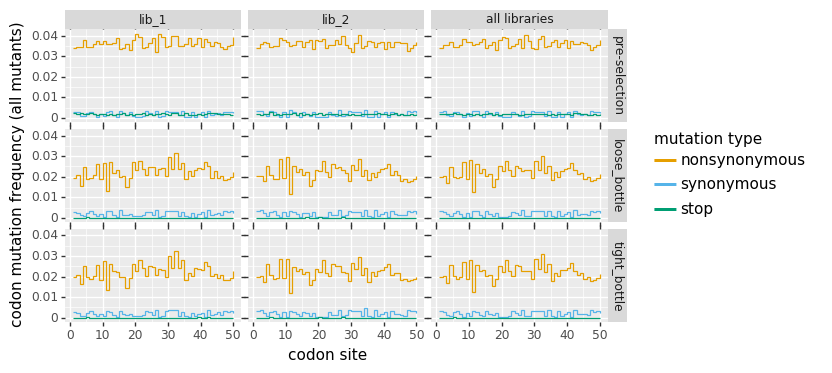

In [35]:
for variant_type in ['single', 'all']:
    p = variants.plotMutFreqs(variant_type=variant_type,
                              mut_type='codon')
    _ = p.draw()

We can plot how thoroughly mutations are sampled in each sample:

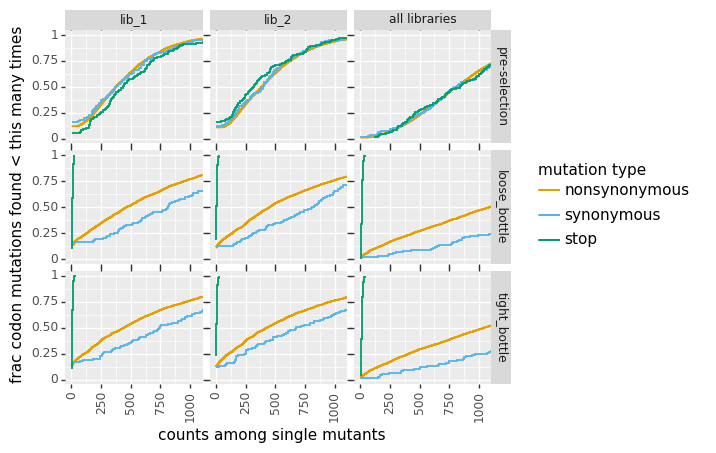

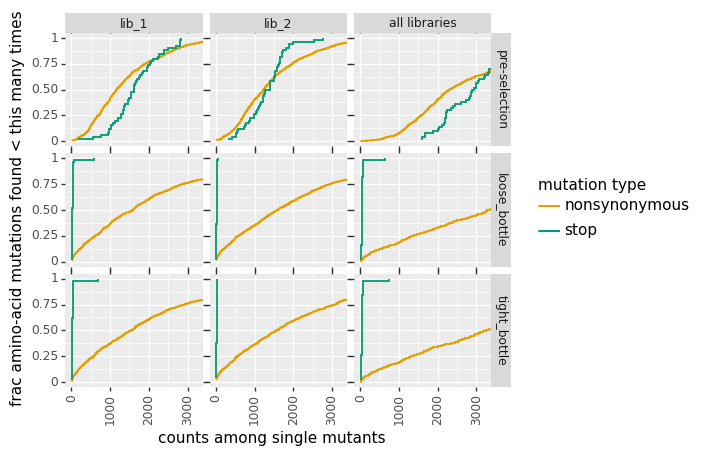

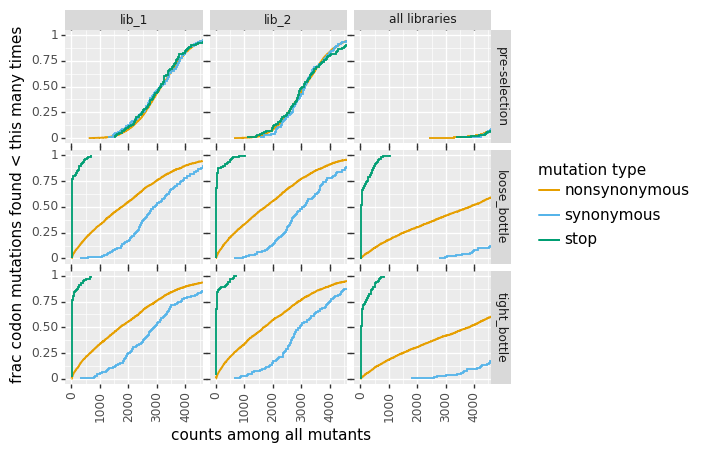

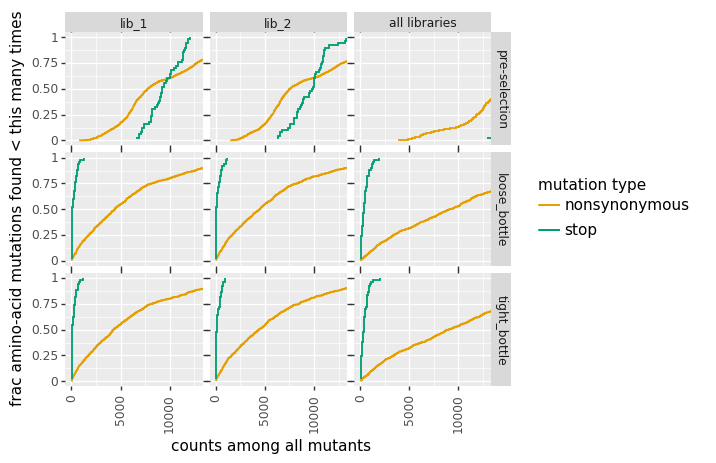

In [36]:
for variant_type, mut_type in itertools.product(
            ['single', 'all'],
            ['codon', 'aa']):
    p = variants.plotCumulMutCoverage(variant_type=variant_type,
                                      mut_type=mut_type)
    _ = p.draw()

## Functional scores for variants
The [CodonVariantTable.func_scores](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.func_scores) method calculates a functional score for each variant based on its change in frequency from pre- to post-selection.

In order to calculate these scores, we need to pair each
post-selection sample with a pre-selection one.
In this case, the pre-selection sample is named 'pre-selection' for all post-selection samples:

In [37]:
func_scores = variants.func_scores('pre-selection')

We can see that the resulting data frame has a functional score (and its
variance) for each barcoded variant:

In [38]:
func_scores.head(n=5)

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,codon_substitutions,n_codon_substitutions,aa_substitutions,n_aa_substitutions
0,lib_1,pre-selection,loose_bottle,AAAAAAACTAAAAGTC,0.131499,0.012626,237,539,666360,1381821,0.5,,0,,0
1,lib_1,pre-selection,loose_bottle,AAAAAAAGACGCGACA,-0.161942,0.040824,78,145,666360,1381821,0.5,,0,,0
2,lib_1,pre-selection,loose_bottle,AAAAAAATAGTCAAAG,-8.519802,4.186261,88,0,666360,1381821,0.5,TCA11TAT,1,S11Y,1
3,lib_1,pre-selection,loose_bottle,AAAAAACATACTTTAC,-0.458140,0.018759,184,278,666360,1381821,0.5,CTG30CAC GTA45TGC,2,L30H V45C,2
4,lib_1,pre-selection,loose_bottle,AAAAAAGATTCCACGT,-3.389638,0.134772,93,18,666360,1381821,0.5,TCC2GTG ATG32GGG CGC48CTT,3,S2V M32G R48L,3


We can also calculate functional scores at the level of amino-acid or codon substitutions rather than at the level of variants. 
This calculation groups all variants with the same substitutions before calculating the functional score.
Here are scores grouping by amino-acid substitutions; we also set `syn_as_wt=True` to include variants with only synonymous mutations in the counts of wild type in this case:

In [39]:
aa_func_scores = variants.func_scores('pre-selection',
                                      by='aa_substitutions',
                                      syn_as_wt=True)
aa_func_scores.head(n=5)

,library,pre_sample,post_sample,aa_substitutions,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_aa_substitutions
0,lib_1,pre-selection,loose_bottle,,0.000000,0.000008,737374,1529501,737374,1529501,0.5,0
1,lib_1,pre-selection,loose_bottle,A39*,-2.512136,0.004860,1607,584,737374,1529501,0.5,1
2,lib_1,pre-selection,loose_bottle,A39* F41S,-9.124054,4.178217,134,0,737374,1529501,0.5,2
3,lib_1,pre-selection,loose_bottle,A39* G50D,-9.491384,4.174739,173,0,737374,1529501,0.5,2
4,lib_1,pre-selection,loose_bottle,A39* G50S,-9.648782,4.173499,193,0,737374,1529501,0.5,2


We can plot the distribution of the functional scores for variants.
These plots are most informative if we classify variants
by the “types” of mutations they have, which we do here using the
[CodonVariantTable.classifyVariants](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable.classifyVariants) method, which adds a  column called `variant_class` to the data frame:

In [40]:
func_scores = CodonVariantTable.classifyVariants(func_scores)

(func_scores
 .head(n=5)
 [['codon_substitutions','aa_substitutions', 'variant_class']]
 )

,codon_substitutions,aa_substitutions,variant_class
0,,,wildtype
1,,,wildtype
2,TCA11TAT,S11Y,1 nonsynonymous
3,CTG30CAC GTA45TGC,L30H V45C,>=2 nonsynonymous
4,TCC2GTG ATG32GGG CGC48CTT,S2V M32G R48L,>=2 nonsynonymous


Now we use [plotnine](https://plotnine.readthedocs.io) to plot the distributions of scores in ggplot2-like syntax, coloring by the variant class.
This plot shows the expected behavior for different variant classes; for instance, stop codon variants tend to have low scores and synonymous variants tend to have wildtype-like (near 0) scores:

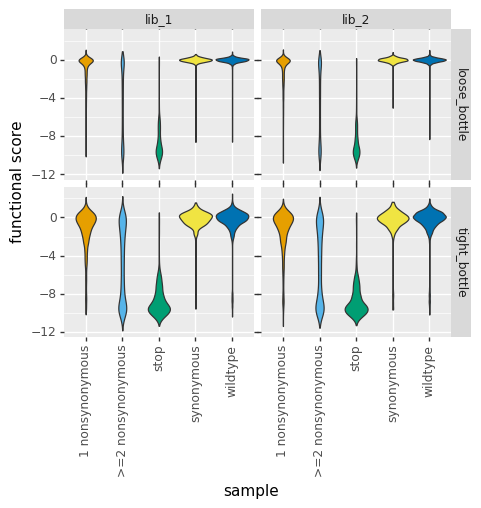

In [41]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('sample') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.5 * len(libs), 
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90)) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Functional scores vs phenotype
Since we simulated the data, we know the *true* observed phenotype for each variant. 
We can therefore correlate the true phenotype with the observed functional score. 
Given how the functional scores were computed, we expect the $\log_2$ of the true phenotype to equal the observed functional score.

Add the true phenotypes to the data frame of functional scores:

In [42]:
func_scores = (
    func_scores
    .assign(observed_phenotype=lambda x: x.apply(
                phenosimulator.observedPhenotype, axis=1),
            latent_phenotype=lambda x: x.apply(
                phenosimulator.latentPhenotype, axis=1),
            log_observed_phenotype=lambda x: scipy.log(
                x.observed_phenotype) / scipy.log(2),
            )
    )

Plot the correlation of the true phenotype and functional score from the simulated experiment.
The plot below shows that the correlations are pretty good until we get to very low-fitness phenotypes, although some points are outliers (probably due to one of the simulated sources of experimental noise):

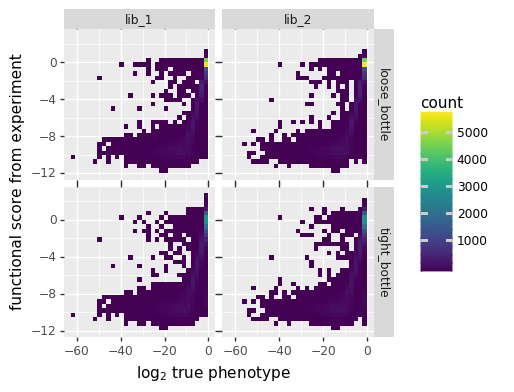

In [43]:
p = (
    ggplot(func_scores,
           aes('log_observed_phenotype', 'func_score')) +
    geom_bin2d() +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2 * len(libs),
                       2 * len(bottlenecks))) +
    xlab('$\log_2$ true phenotype') +
    ylab('functional score from experiment')
    )
_ = p.draw()

Here are the Pearson correlations between the true and measured phenotypes:

In [44]:
corr = (
    func_scores
     .groupby(['library', 'post_sample'])
     .apply(lambda x: x['func_score'].corr(
                      x['log_observed_phenotype'],
                      method='pearson'))
     .rename('Pearson correlation')
     .reset_index()
     .pivot_table(index='post_sample',
                  values='Pearson correlation',
                  columns='library')
     )
corr.round(3)

library,lib_1,lib_2
post_sample,,
loose_bottle,0.845,0.843
tight_bottle,0.802,0.797


The poorest correlation of the functional scores with the log observed phenotype comes at the low end, which may not be very important if we don't care too much about estimating the exact phenotype of very low-fitness variants.
We can effectively "collapse" the low end by exponentiating the functional scores to give the _enrichment_ of a variant in the experiment (we exponentiate with base 2 since that's the base used to calculate the functional scores):

In [45]:
func_scores = (
    func_scores
    .assign(enrichment=lambda x: 2**x['func_score'])
    )

Plot of correlation between observed phenotype and enrichment:

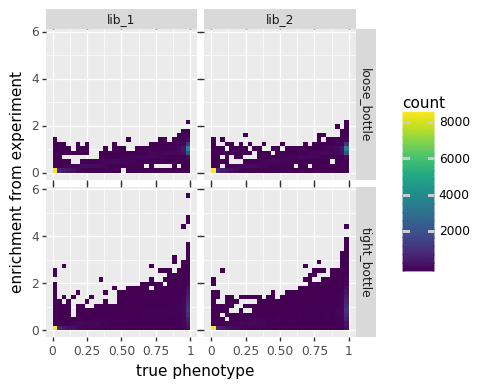

In [46]:
p = (
    ggplot(func_scores,
           aes('observed_phenotype',
               'enrichment')) +
    geom_bin2d() +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2 * len(libs),
                       2 * len(bottlenecks))) +
    xlab('true phenotype') +
    ylab('enrichment from experiment')
    )
_ = p.draw()

Actual correlations:

In [47]:
corr = (
    func_scores
     .groupby(['library', 'post_sample'])
     .apply(lambda x: x['enrichment'].corr(
                      x['observed_phenotype'],
                      method='pearson'))
     .rename('Pearson correlation')
     .reset_index()
     .pivot_table(index='post_sample',
                  values='Pearson correlation',
                  columns='library')
     )
corr.round(3)

library,lib_1,lib_2
post_sample,,
loose_bottle,0.954,0.953
tight_bottle,0.783,0.777


## Aside: formatting plots
The plots returned by the [CodonVariantTable](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable) above are all [plotnine](https://plotnine.readthedocs.io) ggplot objects.
So you can format them differently by setting a different [plotnine theme](https://plotnine.readthedocs.io/en/stable/api.html#themes).

Here is a default themed plot:

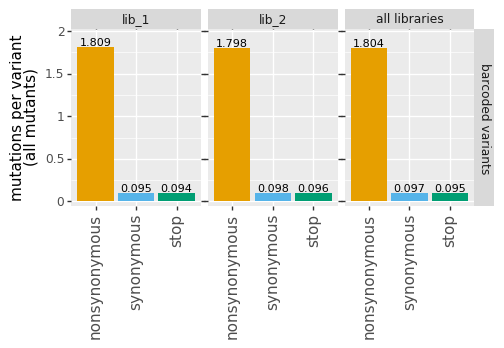

In [48]:
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

We can change the plot theme before plotting.
For instance:

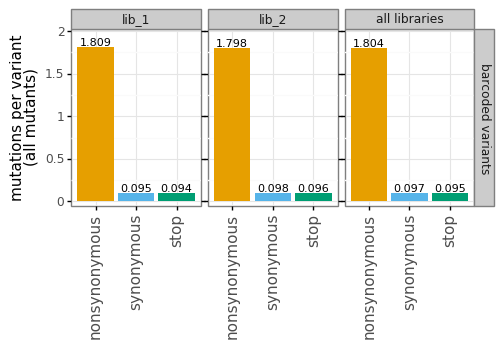

In [49]:
theme_set(theme_bw())
p = variants.plotNumCodonMutsByType('all', samples=None)
_ = p.draw()

Or more silly:

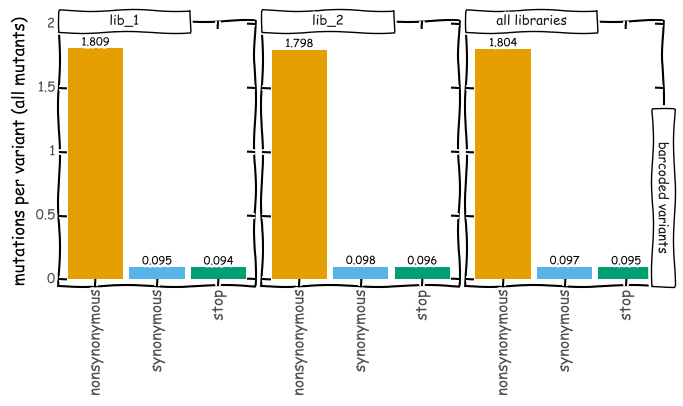

In [50]:
theme_set(theme_xkcd())
p = variants.plotNumCodonMutsByType('all',
                                    samples=None,
                                    heightscale=1.5,
                                    widthscale=1.5)
_ = p.draw()

Note how the above call also used the `heightscale` and `widthscale` options (which exist for all plotting methods of a [CodonVariantTable](https://jbloomlab.github.io/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)) to make the plot larger.

You can also set the orientation differently with `orientation`:

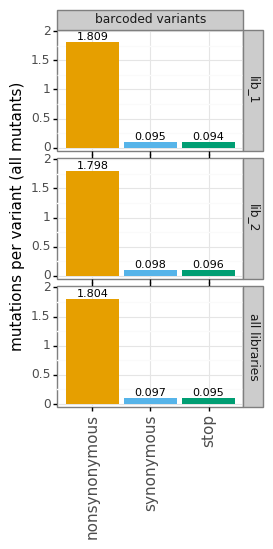

In [51]:
theme_set(theme_bw())
p = variants.plotNumCodonMutsByType('all',
                                    samples=None,
                                    orientation='v')
_ = p.draw()

Or only show some of the facets.
For instance, just show the individual libraries:

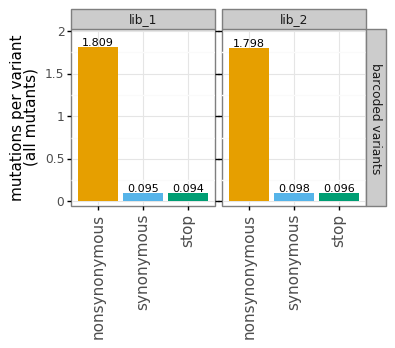

In [52]:
theme_set(theme_bw())
p = variants.plotNumCodonMutsByType('all',
                                    samples=None,
                                    libraries=libs)
_ = p.draw()


Or only the merge of all libraries:

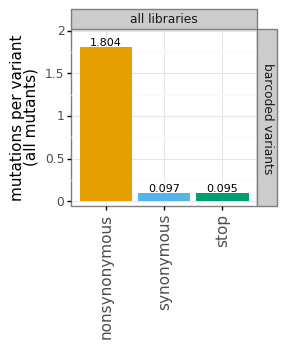

In [53]:
p = variants.plotNumCodonMutsByType('all',
                                    samples=None,
                                    libraries='all_only')
_ = p.draw()

You can also save the plots to image files using their `save` method.
Here we show how to do this, saving the plot as a PNG to a temporary file and then displaying that PNG:

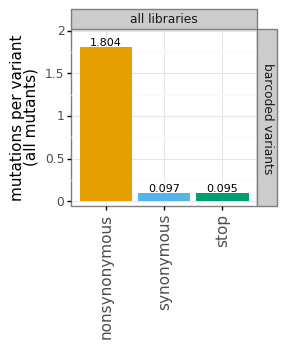

In [54]:
with tempfile.NamedTemporaryFile(suffix='.png') as f:
    p.save(f.name)
    display(Image(f.name))